In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv("spotify_tracks.csv")
df.head

<bound method NDFrame.head of                           id                                           name  \
0     7kr3xZk4yb3YSZ4VFtg2Qt                                       Acoustic   
1     1kJygfS4eoVziBBI93MSYp                                       Acoustic   
2     6lynns69p4zTCRxmmiSY1x                  Here Comes the Sun - Acoustic   
3     1RC9slv335IfLce5vt9KTW                                    Acoustic #3   
4     5o9L8xBuILoVjLECSBi7Vo  My Love Mine All Mine - Acoustic Instrumental   
...                      ...                                            ...   
6295  4uveHSzaz8YEbTF9j6QlCI                             Voyage to Atlantis   
6296  4u15cjyziW2Ewn5Ek3082l                                       L'Oiseau   
6297  56pHPaTeX2O9aVmTFYS8hV                                   The Daintree   
6298  6Ldyc5TsR4kaUsuHKcB2AD                         The Sorcerers Symphony   
6299  3ry0f8ybk8upUBIk8unvmF                                Fiore d'inverno   

            genre    

In [3]:
df.columns

Index(['id', 'name', 'genre', 'artists', 'album', 'popularity', 'duration_ms',
       'explicit'],
      dtype='object')

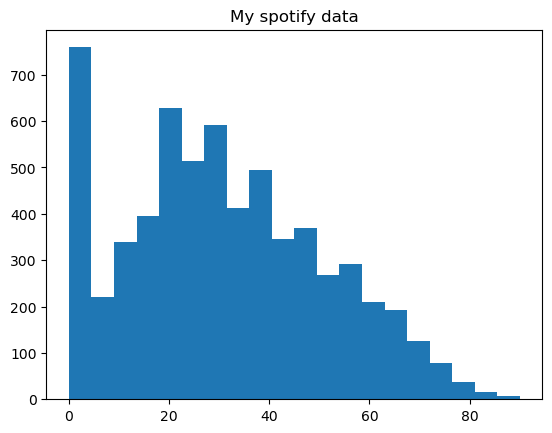

In [4]:
import matplotlib.pyplot as plt
plt.hist(df['popularity'], bins=20)
plt.title("My spotify data")
plt.show()

In [5]:
# data preprocessing

#check for missing values
df.isnull().sum()


id             0
name           0
genre          0
artists        0
album          0
popularity     0
duration_ms    0
explicit       0
dtype: int64

In [6]:
# feature engineering

# Convert duration_ms to minutes
df['duration_min'] = df['duration_ms'] / 60000

# Extract primary artist (first artist in the list)
df['primary_artist'] = df['artists'].str.split(',').str[0]

# Create a binary feature for explicit content
df['is_explicit'] = df['explicit'].astype(int)  # True=1, False=0

In [7]:
# encode categorical values 

# One-Hot Encoding for genre (limit to top 5 genres to avoid too many columns)
top_genres = df['genre'].value_counts().nlargest(5).index.tolist()
df['genre'] = df['genre'].apply(lambda x: x if x in top_genres else 'Other')
genre_dummies = pd.get_dummies(df['genre'], prefix='genre')

# Concatenate with original DataFrame
df = pd.concat([df, genre_dummies], axis=1)

In [8]:
# split the data into train test set

# Define X (features) - Just numeric columns for simplicity
X = df[['popularity', 'duration_ms']]  # Example: Using only 2 features

# Define y (target) - Create binary 'liked' column (0/1)
df['liked'] = (df['popularity'] > 70).astype(int)  # Example: Liked if popularity > 70
y = df['liked']

print("Features (X):\n", X.head())
print("\nTarget (y):\n", y.head())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Features (X):
    popularity  duration_ms
0          58       172199
1          57       172202
2          42       144786
3          46       116573
4          33       133922

Target (y):
 0    0
1    0
2    0
3    0
4    0
Name: liked, dtype: int32


In [9]:
## train the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

#predict on test set
y_pred = model.predict(X_test)

# evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 1.00


In [10]:
# impove the model

# Feature engineering example: Add a new feature
df['duration_min'] = df['duration_ms'] / 60000  

# Hyperparameter tuning (simple grid search)
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10]
}

grid_search = GridSearchCV(model, params, cv=3)
grid_search.fit(X_train, y_train)
print(f"Best params: {grid_search.best_params_}")

Best params: {'max_depth': None, 'n_estimators': 50}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1224
           1       1.00      1.00      1.00        36

    accuracy                           1.00      1260
   macro avg       1.00      1.00      1.00      1260
weighted avg       1.00      1.00      1.00      1260



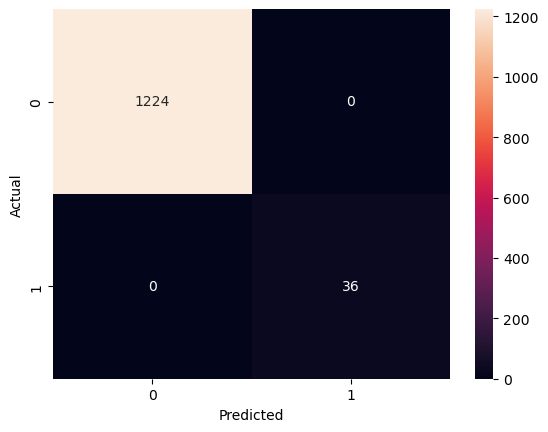

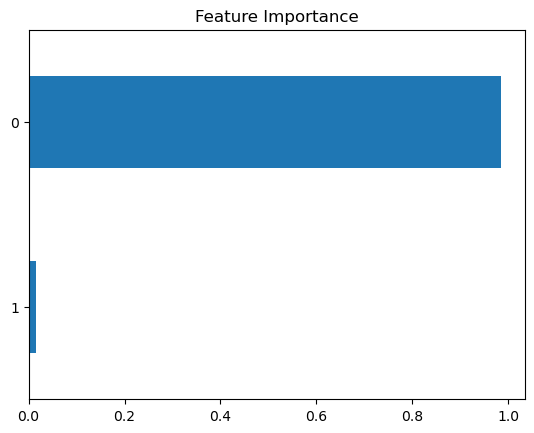

In [11]:
# evaluate and interpret

from sklearn.metrics import classification_report, confusion_matrix

# Detailed metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance
importance = pd.Series(model.feature_importances_)
importance.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.show()

In [12]:
# Save model
import joblib
joblib.dump(model, 'spotify_model.pkl')

# Mini Flask app (save as app.py)
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)
model = joblib.load('spotify_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    features = [data['danceability'], data['energy'], data['duration_ms'], data['tempo']]
    prediction = model.predict([features])[0]
    return jsonify({'liked': bool(prediction)})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\Administrator\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
# 5. Save model (now 'model' exists!)
joblib.dump(model, 'spotify_model.pkl')
print("Model saved successfully!")

Model saved successfully!
